# Initialisation

## Importation des bibliothèques

In [5]:
## (1) Téléchargement des données
import os
import tarfile
from six.moves import urllib

## (2) Chargement des données
import pandas as pd

## (3) Fonctions de représentation des données
#%matplotlib inline # notebook Jupyter seulement 
import matplotlib.pyplot as plt

## (4) Création d'un jeu de test et d'un d'entrainement
import numpy as np
import hashlib
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

## (7) Préparation des données
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

## (0) Sélectionner un modèle
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.svm import SVR

# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone

/var/folders/l4/tj2026g138127nm7gbw5ljb00000gn/T/ipykernel_25149/2958115572.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd



# (1) Téléchargement des données


In [6]:

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/" 
    # lien vers le dossier de téléchargement
    #
HOUSING_PATH = "datasets/housing" # chemin vers le dossier où sont stockés les fichiers
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz" # lien de téléchargement

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH): 
    if not os.path.isdir(housing_path): # Création du dossier housing_path Si non existence
        os.makedirs(housing_path) 
    tgz_path = os.path.join(housing_path, "housing.tgz") # Mise en mémoire du fichier tgz_path ?
    urllib.request.urlretrieve(housing_url, tgz_path) # Téléchargement du fichier tgz
    housing_tgz = tarfile.open(tgz_path) # Mise en mémoire de l'archive tgz
    housing_tgz.extractall(path=housing_path) # Décompression de l'archive dans housing_path
    housing_tgz.close()

#fetch_housing_data() # Téléchargement du fichier




# (2) Chargement des données


In [7]:

# IN: housing_path: <str> chemin vers un dossier contenant un fichier csv
#     name: <str> nom du fichier csv
# OUT: <DataFrame> Objet panda contenant les données
def load_housing_data(housing_path=HOUSING_PATH, name = 'housing'):
    csv_path = os.path.join(housing_path, name + ".csv") # Mise en mémoire du fichier csv
    return pd.read_csv(csv_path) # Création de l'objet panda <DataFrame>

    # Chargement des données
housing = load_housing_data() # <class 'pandas.DataFrame'>

# (3) Fonctions de représentation des données

In [8]:
# print('\n\n head \n', housing.head()) # Affichage des cinq premières lignes de données 
# print('\n\n info \n', housing.info()) # Effectifs et types des variables par label 
print('\n\n value_counts \n', housing["ocean_proximity"].value_counts()) # Effectifs par valeur des variables du label 'ocean_proximity'
# print('\n\n describe \n', housing.describe()) # Données statistiques de chaque label 

# housing.hist(bins=50, figsize=(20,15)) # Histogramme des effectifs pour chaque label 
# plt.show()



 value_counts 
 ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64



# (4) Création d'un jeu de test et d'un d'entrainement
# (5) Solution par stratification avec Scikit-Learn

- Création d'un label dont la distribution dans chaque jeu sera identique.
- Echantillonage avec StratifiedShuffleSplit (SciKit)
- Vérification des répartitions
- Suppression du label créé




## a) Nouveau label

On définit ```income_cat``` par la valeur de ```median_income``` réduite entre 0 et 5 (division puis remplacement des valeurs >5).
    

In [5]:
  
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) # np.ceil arrondie
    # housing["median_income"]: <panda.core.series.Series>
    # 
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # Remplace les données >5 par 5
    # where(): Replace values where the condition is False
    #          cond (Condition)
    #          other = NoDefault (Valeur de remplacement)
    #          inplace = False (Opère directement sur l'instance)
    #


* Remarque: On ne divise pas par le max, car s'il n'y a que quelques valeurs très hautes, on réduira la précision du modèle.

Affichage de l'histogramme:

<Axes: >

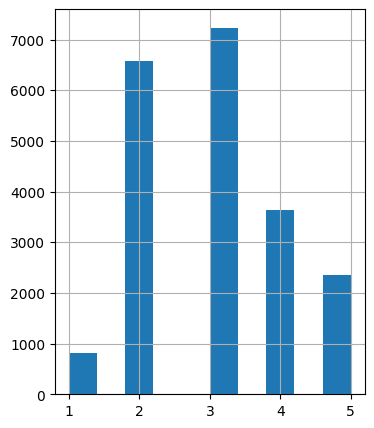

In [6]:
plt.figure(0)
housing["income_cat"].hist(bins = 10, figsize = (4,5)) 

## b) Echantillonage

On définit l'instance split qui contient la méthode split pour partager le jeu de données:


In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # Fonction SciKit
    # split: <class> (n_splits = 10, (Number of re-shuffling & splitting iterations) (Pour une validation croisée)
    #                test_size = None, (<float>: entre 0 et 1, représente un pourcentage
    #                train_size = None,   <int>: represents the absolute number of test samples)
    #                random_state = None (Définit la source, permet de reproduire les suites aléatoires)
    #              )
    # 


On définit strat_train et strat_test puis on les remplit avec split.split()


In [8]:
strat_train = []
strat_test = []

for train_index, test_index in split.split(housing, housing["income_cat"]):
    # split.split() renvoie un générateur contenant les labels du jeu de donnée d'entrainement, et de celui de test
    #
    #      IN: X <array-like of shape> (Données d'entrainement)
    #          y <array-like of shape> (Label utilisé pour la stratification; étiquette en supervisé)
    #     OUT: train, test <tuple of np.ndarray> 
    #
    print('\n\n', housing.loc[train_index[0]], test_index, len(test_index))
    strat_train += [housing.loc[train_index]] # <pd.DataFrame> (Jeu d'entrainement)
    strat_test += [housing.loc[test_index]] # <pd.DataFrame> (Jeu de test)
    
strat_train_set = strat_train[0]
strat_test_set = strat_test[0]



 longitude             -121.46
latitude                38.52
housing_median_age       29.0
total_rooms            3873.0
total_bedrooms          797.0
population             2237.0
households              706.0
median_income          2.1736
median_house_value    72100.0
ocean_proximity        INLAND
income_cat                2.0
Name: 12655, dtype: object [ 5241 17352  3505 ... 17223 10786  3965] 4128


In [9]:
strat_train[0].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,2.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,5.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,2.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,2.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,3.0


## c) Vérifications

La distribution de ```income_cat``` doit être la même dans le jeu complet, celui d'entrainement et celui de test.

Text(0.5, 1.0, 'Test')

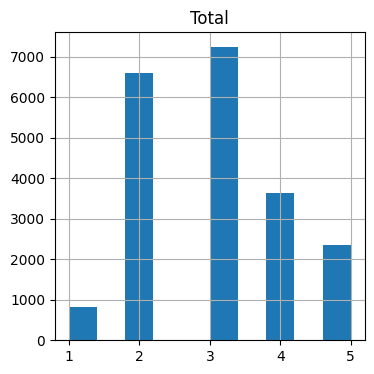

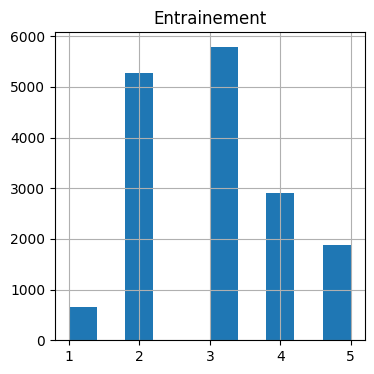

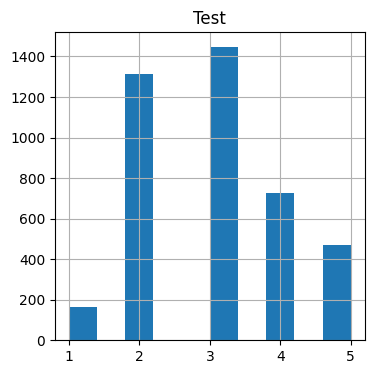

In [10]:
def pourcentage(dataFrame):
    return dataFrame["income_cat"].value_counts() / len(dataFrame)


plt.figure(1)
totalHist = housing['income_cat'].hist(bins = 10, figsize = [4, 4])
totalHist.set_title('Total')

plt.figure(2)
trainHist = strat_train_set['income_cat'].hist(bins = 10, figsize = [4, 4])
trainHist.set_title('Entrainement')

plt.figure(3)
testHist = strat_test_set['income_cat'].hist(bins = 10, figsize = [4, 4])
testHist.set_title('Test')



Même vérification sous la forme d'un tableau:

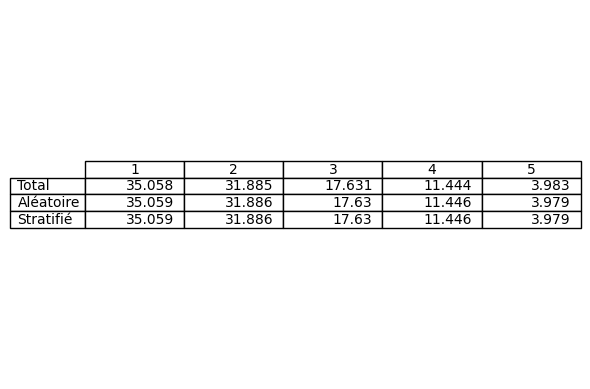

In [11]:
datasFr = [housing, strat_train_set, strat_train_set]

fig, ax = plt.subplots()
data = [[round(pcg * 100, 3) for pcg in pourcentage(dataFr)] for dataFr in datasFr]
column_labels=["Total", "Aléatoire", "Stratifié"] #, 'Erreur Aléa. (%)', 'Erreur Strat. (%)']
ax.axis('tight')
ax.axis('off')
ax.table(cellText = data, rowLabels = column_labels, loc = 'center', colLabels = [str(i) for i in range(1,6)])

plt.show()


## d) Suppression et copie de données

On supprime le label ```income_cat``` qui n'a servi qu'à définir les jeux d'entrainement et de test:


In [12]:
for set in (strat_train_set, strat_test_set, housing): 
    set.drop(["income_cat"], axis=1, inplace=True)

On copie les données pour ne pas les abîmer:

In [13]:
Train = strat_train_set.copy()
Test = strat_test_set.copy()


# (6) Visualisation des données


## a) Données géographiques

Affichage géographique de la population et des revenues:

<Axes: xlabel='longitude', ylabel='latitude'>

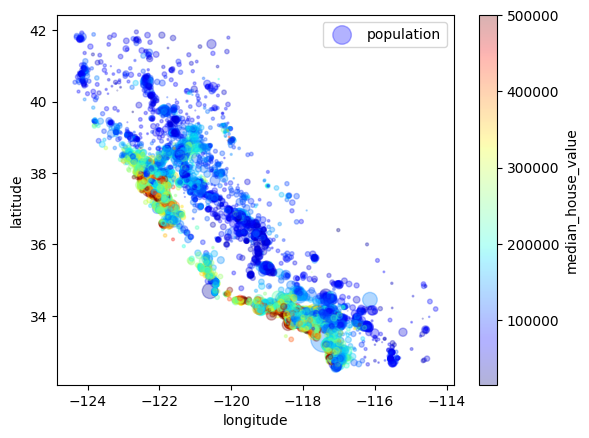

In [14]:
Train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3, 
            s=Train["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)


* Remarque: Les prix semblent liés à la localisation (proximité à l'océan) et à la densité de population, 
un partionnement semble judicieux.
Cette règle est complexe à mettre en oeuvre car elle ne s'applique pas partout (au nord par expemple).



## b) Corrélation

Affichage des coefficient de corrélation de Pearson par rapport au label 'median_house_value':

*Formule*: r = Cov(X, Y) / (Var(X)Var(y)) ** 1/2


In [15]:
corr_matrix = Train.corr(numeric_only=True)
x = corr_matrix['median_house_value'].sort_values(ascending = False)

print(x)


median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


Affichage de graphique avec (x, y) = (attributes[i], attributes[j]):


array([[<AxesSubplot: xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot: xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot: xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot: xlabel

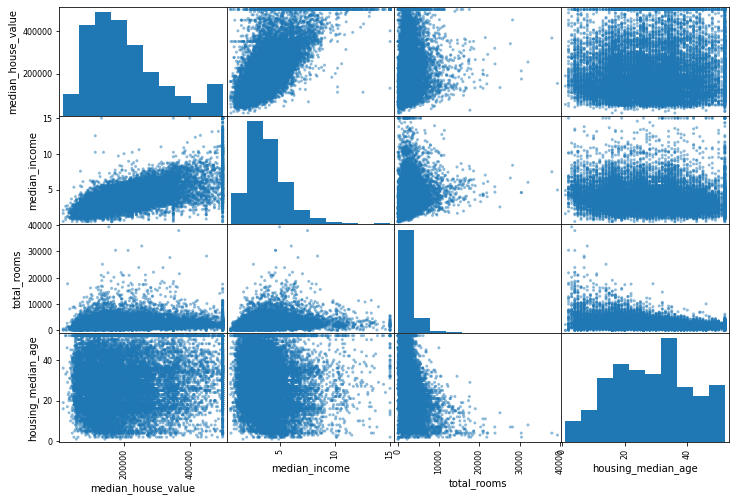

In [16]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"] # Séléction des variables
                                                                               # qui semblent corrélées
pd.plotting.scatter_matrix(Train[attributes], figsize=(12, 8))
    # frame <pd.DataFrame>
    # alpha = 0.5 
    # figsize = None
    # grid = False (True pour montrer )
    # diagonal = 'hist' ('kde' pour Kernel Density Estimation)
    # **kwargs
    #

   
* Remarque: Une corrélation très forte est observée,
    mais on aperçoit des lignes aux alentours de 280k, 350k, 450k.
    Il serait judicieux de supprimer les données responsables 
    pour éviter que les algos reproduisent ces phénomènes.


## c) Combinaison de variables

Le nombre de pièce par logement est plus intéressant que le nombre de pièce par district, idem pour </br>
le nombre de chambre par rapport au nombre de pièces plutôt que par district.

On s'interresse aussi au nombre de personne par logement.

Création de nouveaux labels:
    


median_house_value           1.000000
median_income                0.687151
rooms_per_households         0.146255
total_rooms                  0.135140
housing_median_age           0.114146
households                   0.064590
total_bedrooms               0.047781
population_per_households   -0.021991
population                  -0.026882
longitude                   -0.047466
latitude                    -0.142673
bedrooms_per_rooms          -0.259952
Name: median_house_value, dtype: float64


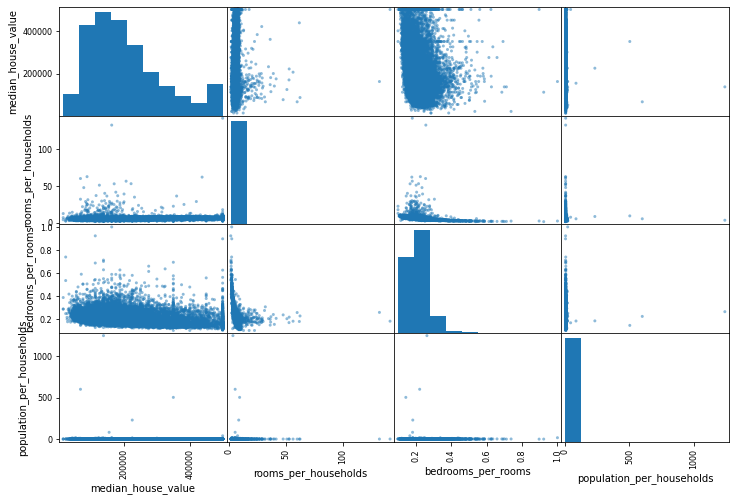

In [17]:
Train['rooms_per_households'] = Train['total_rooms'] / Train['households']
Train['bedrooms_per_rooms'] = Train['total_bedrooms'] / Train['total_rooms']
Train['population_per_households'] = Train['population'] / Train['households']

attributes = ['median_house_value', 'rooms_per_households', 'bedrooms_per_rooms', 'population_per_households']
pd.plotting.scatter_matrix(Train[attributes], figsize = (12, 8))

corr_matrix = Train.corr(numeric_only=True) # Calcul du coefficient de corrélation de Pearson r = Cov(X, Y) / (Var(X)Var(y)) ** 1/2
x = corr_matrix['median_house_value'].sort_values(ascending = False)
print(x)

* Remarque: On a modifié l'instance Train. Il peut arriver qu'on modifie également Test. </br>On reprendra donc de nouvelles instances de ```strat_train_set``` et de ```strat_test_set``` pour la suite.

# (7) Préparation des données

### Variable numérique
- Complétion des données avec ```SimpleImputer```
- Vérification

### Variable catégorique
- On quantifie un label avec ```LabelEncoder```
- A partir du label quantifié, on crée un label par valeur avec ```OneHotEncoder```

*ou alors*
- On utilise ```LabelBinarizer``` (2 en 1)

In [18]:
Train = strat_train_set.drop('median_house_value', axis = 1) # axis <int = 0, 1> Si le label est sur les l ou col ?
Train_labels = strat_train_set['median_house_value'].copy()

## a) Gestion des variables numériques

Solution manuelle:

In [19]:
median = Train['total_bedrooms'].median() # Attention à conserver cette variable pour le jeu de test
Train['total_bedrooms'].fillna(median, inplace = True)
Train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


Solution avec SciKit

In [20]:
imputer = SimpleImputer(strategy = 'median') # Transformateur permettant de compléter les données
    # missing_values = nan (Valeur à remplacer)
    # strategy = 'mean' ('median', 'most_frequent', 'constant')
    # fill_value = None (Si strategy == 'constant', remplace par fill_value)
    # verbose = 0 (Controls the verbosity)
    # copy = True (Produit une copie. Voir exception)
    # add_indicator = False
    #
Train_num = Train.drop('ocean_proximity', axis = 1) # <pd.DataFrame>
imputer.fit(Train_num)
Train_tr_np = imputer.transform(Train_num) # <class 'numpy.ndarray'>
Train_tr = pd.DataFrame(Train_tr_np, columns = Train_num.columns) # <pd.DataFrame>

```Train_tr``` est un tableau complété par les valeurs spécifiées; <br>
La mediane de chaque attribut est stocké dans ```imputer.statistics_```:


In [21]:
print(Train_tr.info())
#print(imputer.statistics_, Train_num.median().values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB
None



* Voir *De* *la* *conception* *de* *SciKit-Learn* (p.60)

## b) Gestion des variables catégoriques

LabelEncoder() + OneHotEncoder() = ...

In [22]:
labEncoder = LabelEncoder() # Transformateur permettant de remplacer des valeurs d'un label par des int
Train_cat = Train["ocean_proximity"]
Train_cat_encoded = labEncoder.fit_transform(Train_cat) # # <numpy.ndarray>
    

# Remarque: '<1H OCEAN' et 'NEAR OCEAN' sont représentés par 0 et 4 alors qu'ils sont proches
#           Pour remédier à cela, on utilise OneHotEncoder de Scikit
#

oneHotEncoder = OneHotEncoder() # Transformateur permettant de créer un label par valeur
Train_cat_1hot = oneHotEncoder.fit_transform(Train_cat_encoded.reshape(-1,1)) # <scipy.sparse._csr.csr_matrix>



... LabelBinarizer() !


In [23]:
encoder = LabelBinarizer(sparse_output = True) # sparse_output = False (Renvoie une matrice creuse si True)
Train_cat_1hot = encoder.fit_transform(Train_cat)
print(Train_cat_1hot)
    # Idem que pour OneHotEncoder(), mais avec des 1 au format <int>
    #

  (0, 1)	1
  (1, 4)	1
  (2, 1)	1
  (3, 4)	1
  (4, 0)	1
  (5, 3)	1
  (6, 0)	1
  (7, 0)	1
  (8, 0)	1
  (9, 0)	1
  (10, 1)	1
  (11, 0)	1
  (12, 1)	1
  (13, 1)	1
  (14, 4)	1
  (15, 0)	1
  (16, 0)	1
  (17, 0)	1
  (18, 3)	1
  (19, 0)	1
  (20, 1)	1
  (21, 3)	1
  (22, 1)	1
  (23, 0)	1
  (24, 1)	1
  :	:
  (16487, 1)	1
  (16488, 0)	1
  (16489, 4)	1
  (16490, 4)	1
  (16491, 1)	1
  (16492, 1)	1
  (16493, 0)	1
  (16494, 0)	1
  (16495, 0)	1
  (16496, 1)	1
  (16497, 0)	1
  (16498, 4)	1
  (16499, 0)	1
  (16500, 0)	1
  (16501, 1)	1
  (16502, 1)	1
  (16503, 1)	1
  (16504, 1)	1
  (16505, 0)	1
  (16506, 0)	1
  (16507, 0)	1
  (16508, 1)	1
  (16509, 0)	1
  (16510, 0)	1
  (16511, 1)	1




## a) Transformateur sur mesure

### Principe: 
- Créer des classes et définir des méthodes ```.fit()``` et ```.transform()```
- Ajouter ```TransformerMixin``` en classe mère pour obtenir la méthode ```.fit_transform()```
- Ajouter ```BaseEstimator``` en classe mère pour obtenir les méthodes ```.get_params()``` et ```.set_params()```, utiles pour le réglage automatique des hyperparamètres

### En pratique:

##### Déclaration de la classe

Schéma:
```
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True) # Stock le paramètre. ni *args ni **kargs

    def fit(self, X, y = None) # Renvoie self
    
    def transform(self, X, y = None) # Renvoie X modifié
    
```

Implémentation:

In [24]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True): # Stock le paramètre. ni *args ni **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room 
    
    def fit(self, X, y = None): # Renvoie self
        return self
    
    def transform(self, X, y = None): # Renvoie X modifié
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix] 
        population_per_household = X[:, population_ix] / X[:, household_ix] 
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else: 
            return np.c_[X, rooms_per_household, population_per_household]

##### Instanciation du transformateur et transformation des données

In [25]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False) 
Train_extra_attribs = attr_adder.transform(Train.values) # <numpy.ndarray>

##### Résultat
```
    # [[-121.46 38.52 29.0 ... 'INLAND' 5.485835694050992 3.168555240793201]
    #  [-117.23 33.09 7.0 ... 'NEAR OCEAN' 6.927083333333333 2.6236979166666665]
    #  ...
    # [-122.14 39.97 27.0 ... 'INLAND' 5.477157360406092 3.1725888324873095]]
    #
    # <class 'numpy.ndarray'>
    #
```
* Remarque: L'hyperparamètre add_bedrooms_per_room permet de vérifier l'utilité de la combinaison de variable. On essaiera avec les valeurs True et False.

## b) Calibrage des variables

Les algos fonctionnent mieux (sauf exception) avec des variables calibrées. </br>
Par exemple, le revenu moyen est compris entre 0 et 15, alors que le nombre total de pièce va de 6 à 39 320.

On peut utiliser la méthode des min-max, avec ```scikit.preprocessing.MinMaxScaler```, 
</br> ou la normalisation, avec ```scikit.preprocessing.StandardScaler```.

In [26]:
def min_max(data, mine = 0, maxe = 1): # Méthode des min-max, utiliser scikit.preprocessing.MinMaxScaler
    data_calibre = (data - data.min()) / (data.max() - data.min()) * (maxe - mine) + mine
    return data_calibre

def normalisation(data): # Méthode par normalisation, utiliser scikit.preprocessing.StandardScaler 
    data_calibre = (data - data.mean())/data.std()
    return data_calibre

Utilisation:

In [27]:
transformer = StandardScaler()
Train_std_tr = transformer.fit_transform(Train.drop('ocean_proximity', axis = 1)) # <numpy.ndarray>

# (8) Pipeline de transformation

Pour automatiser les transformations, dans un ordre donnée, on utilise des pipelines:

In [28]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")), 
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())])
Train_num_tr = num_pipeline.fit_transform(Train_num) # <numpy.ndarray>

- On fournit à Pipeline des couples nom/estimateur définissant une suite d'étape. 
- Les noms sont libres de choix. 
- Les estimateurs doivent être des transformateurs (ie. avoir une méthode .fit_transform()). 
- La méthode Pipeline.fit() appelle chacune des méthodes fit_transform() des transformateurs, </br>puis la méthode .fit() du dernier estimateur. (A tester: la méthode ```transform()``` du dernier transformateur n'est pas appelé ?)


Pour gérer LabelBinarizer en plus, on a besoin d'un transformateur supplémentaire afin de récupérer les données souhaitées:

In [29]:
class DataFrameSelector(BaseEstimator, TransformerMixin):

    def __init__(self, label_selected):
        self.label_selected = label_selected  

    def fit(self, X, y = None):
        return self

    def transform(self, X): # Renvoie les données de X dont le label est sélectionné
        return X[self.label_selected]

On traite les labels numériques et les labels catégoriques à part:

In [30]:
num_attribs = list(Train_num) 
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)), # Sélection des données
                         ('imputer', SimpleImputer(strategy="median")), # Complétion des données
                         ('attribs_adder', CombinedAttributesAdder()), # Création de nouveaux labels par combinaison
                         ('std_scaler', StandardScaler())]) # Normalisation des données
                         
cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)), # Sélection des données
                         ('onehot', OneHotEncoder())]) # Numérisation et création de nouveaux labels pour chaque valeur

Puis on rassemble les deux pipelines en une:

In [31]:
full_pipeline = FeatureUnion(transformer_list =
                             [("num_pipeline", num_pipeline),
                              ("cat_pipeline", cat_pipeline)],
                            n_jobs = -1)

NewTrain = full_pipeline.fit_transform(Train) # <scipy.sparse._csr.csr_matrix>

# (9) Pipelines optimales

On prend un nouveau jeu de données:

In [32]:
Train = strat_train_set.copy()
Test = strat_test_set.copy()

On définit les labels:

In [33]:
Train_labels = list(Train)

num_labels = list(Train.drop(['ocean_proximity', 'median_house_value'], axis = 1, inplace = False))
cat_labels = ['ocean_proximity']
added_labels = ['rooms_per_household', 'population_per_household', 'bedrooms_per_rooms']
ocean_labels = Train['ocean_proximity'].value_counts().index.tolist()

labels_index = pd.Index(num_labels + added_labels + ['median_house_value'] + ocean_labels)

* Remarque: On traite ```mediane_house_value``` à part. Il s'agit de la valeur à prédire, on ne s'en sert donc pas comme paramètre du modèle. De plus, cela évite de devoir le reconvertir par la suite (et donc de stocker la mediane et l'écart-type).

On définit les transformateurs:

In [34]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add = True):
        self.add = add
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        
        if self.add:
            bedrooms_per_rooms = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_rooms]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribs_names = []):
        self.attribs_names = attribs_names
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return X[self.attribs_names]

Puis les pipelines:

In [35]:
num_pipe = Pipeline([('select', DataFrameSelector(num_labels)),
                     ('imputer', SimpleImputer(strategy = 'median')),
                     ('lab_add', CombinedAttributesAdder()),
                     ('standardisation', StandardScaler())])

cat_pipe = Pipeline([('select', DataFrameSelector(cat_labels)),
                     ('OneHot', OneHotEncoder(categories = [ocean_labels], handle_unknown = 'ignore')),
                     ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0, copy = True))])

house_value_pipe = Pipeline([('select', DataFrameSelector(['median_house_value'])),
                             ('imputer', SimpleImputer(strategy = 'median'))])

full_pipeline = FeatureUnion(transformer_list = 
                            [('numeric', num_pipe),
                            ('house_value', house_value_pipe),
                            ('categor', cat_pipe)])

Transformation des données:


In [36]:
Train_prepared_scp = full_pipeline.fit_transform(Train) # <scipy.csr_matrix>
Test_prepared_scp = full_pipeline.fit_transform(Test) # <scipy.csr_matrix>

Train_prepared = pd.DataFrame(Train_prepared_scp.todense(), columns = labels_index) # Données d'entrainement
Labels_prepared = Train_prepared['median_house_value'].copy() # Etiquettes pour l'entrainement

Test_prepared = pd.DataFrame(Test_prepared_scp.todense(), columns = labels_index) # Données de test
Labels_true = Test_prepared['median_house_value'].copy() # Etiquettes pour le test


##### Résumé des variables:

* ```strat_train_set``` et ```strat_test_set```, les jeux de données propres. <br>
* ```Train_prepared``` et ```Labels_prepared```, le jeu d'entrainement préparé et les étiquettes associées. <br>
* ```Test_prepared``` et ```Labels_true```, le jeu de test préparé et les étiquettes associées. <br>

On passe à présent à l'entrainement des modèles avec Train_prepared et Labels_prepared pour prédire ```Labels_true``` à partir de ```Test_prepared```.

# (0) Entrainement


### a. Préparation des données à estimer et des labels

In [37]:
Train_prepared_scp = full_pipeline.fit_transform(Train) # <scipy.csr_matrix>
Test_prepared_scp = full_pipeline.fit_transform(Test) # <scipy.csr_matrix>

Train_prepared = pd.DataFrame(Train_prepared_scp.todense(), columns = labels_index) # Données d'entrainement
Labels_prepared = Train_prepared['median_house_value'].copy() # Etiquettes pour l'entrainement

Test_prepared = pd.DataFrame(Test_prepared_scp.todense(), columns = labels_index) # Données de test
Labels_true = Test_prepared['median_house_value'].copy() # Etiquettes pour le test

### b. Déclaration des modèles

In [38]:
lin_reg = LinearRegression()
    # fit_intercept = True (Whether to calculate the intercept for this model. 
    #                       If set to False, no intercept will be used in calculations 
    #                       (i.e. data is expected to be centered).)
    # copy_X = True (if False, X may be overwritten)
    # n_jobs = None (The number of jobs to use for the computation. 
    #                This will only provide speedup in case of sufficiently large problems, 
    #                that is if firstly n_targets > 1 and secondly X is sparse or if positive is set to True. 
    #                None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. 
    #                See Glossary for more details.)
    # positive = False (When set to True, forces the coefficients to be positive. 
    #                   This option is only supported for dense arrays.)
    #
tree_reg = DecisionTreeRegressor()
    # criterion = “squared_error”; in “friedman_mse”, “absolute_error”, “poisson” 
    #                              (Fonction de mesure de la qualité d'un split)
    # splitter = 'best'; or 'random' (Méthode pour choisir les splits à chaque noeud)
    # max_depth = None; or <int> (Définit la profondeur maximale de l'arbre.
    #                             None: l'algo s'arrête jusqu'à ce que les feuilles soient pures
    #                                 ou jusqu'à ce que chaque feuille aie moins de min_samples_split observations)
    #
    # min_samples_split = 2; or <int>, <float> (Si <float>, ceil(min_samples_split * n_samples) est le min)
    # min_samples_leaf = 1; <int> or <float> (Le minimum de feuilles sur lesquelles débouche un noeud
    #                                            pour que ce dernier soit considéré; idem que ci-dessus)
    # min_weight_fraction_leaf = 0.0; <float> (Idem que ci-dessus pour le poids; 
    #                                             ignoré si sample_weight n'est pas donné dans .fit())
    # max_features = None 
    #
    # random_state = None
    # max_leaf_nodes = None
    # min_impurity_decrease = 0.0
    # ccp_alpha = 0.0
    #
forest_reg = RandomForestRegressor()
    # n_estimators = 100; <int> (Nombre d'arbre)
    # idem que ci-dessus (sauf splitter, random_state)
    # bootstrap = True
    # oob_score = False
    # n_jobs = None
    # verbose = 0
    # warm_start = False
    # max_samples = None
    #
svr_reg = SVR(kernel = 'poly', degree = 2, C = 100, epsilon = 0.9)
    # kernel = 'rbf'; {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable
    # degree = 3; <int> (ignoré si kernel != 'poly')
    # gamma = 'scale'; {‘scale’, ‘auto’} or <float> (Si kernel in ('rbf', poly, sigmoid)
    #                                                scale -> 1 / (n_features * X.var())
    #                                                auto -> 1 / n_features)
    # coef0 = 0.0; <float> (Para indépendant, significatif si kernel in ('poly', 'sigmoid'))
    # tol = 0.001; <float> (Tolérance pour stoper criterion)
    #
    # C = 1.0; <float> strictement positif
    # epsilon = 0.1 <float>
    #
    # shrinking = True 
    # cache_size = 200; <float> (Spécifie la mémoire cache du noyau en MB)
    # verbose = False
    # max_iter = - 1; <int> (Hard limit on iterations within solver, or -1 for no limit)
    #

### c. Entrainement

In [39]:
lin_reg.fit(Train_prepared, Labels_prepared)
Labels_lin_reg = lin_reg.predict(Test_prepared)

tree_reg.fit(Train_prepared, Labels_prepared)
Labels_tree_reg = tree_reg.predict(Test_prepared)

forest_reg.fit(Train_prepared, Labels_prepared)
Labels_forest_reg = forest_reg.predict(Test_prepared)

svr_reg.fit(Train_prepared, Labels_prepared)
Labels_svr_reg = svr_reg.predict(Test_prepared)



# Evaluation

### a. RMSE

On calcule la distance p-ieme entre les étiquettes réelles et celles prédites.

In [40]:
def RMSE(x, y, titre = 'un modèle', p = 2, aff = True):
        if type(x) and type(y) is list or True:
            if len(x) == len(y) or True:
                if p == 0:
                    score = max(x - y)
                elif p > 0:
                    somme = 0
                    for i in range(len(x)):
                        somme += abs(x[i] - y[i]) ** p
                    score = (somme / len(x)) ** (1/p)
                else: print('Mauvaise valeur de p')
                if aff: print('\nScore pour', titre, ': ', score)
                return score
            else: print('x et y ne font pas la même longueur: ', len(x), len(y))
        else: print('x ou y n\'est pas une liste')

In [41]:
RMSE(Labels_true, Labels_lin_reg, titre = 'lin_reg', p = 0)
RMSE(Labels_true, Labels_tree_reg, titre = 'tree_reg')
RMSE(Labels_true, Labels_forest_reg, titre = 'forest_reg')
RMSE(Labels_true, Labels_svr_reg, titre = 'svr_reg')


Score pour lin_reg :  2.255546860396862e-10

Score pour tree_reg :  96.10258896923197

Score pour forest_reg :  72.53383241355628

Score pour svr_reg :  30260.794569470785


30260.794569470785

### b. Validation croisée en K-passes

On découpe le jeu d'entrainement en K parties. On entraine successivement le modèle sur K - 1 parties et on calcule le score sur la partie restante.

In [42]:
def crossValid(model, titre = 'un modèle'):
        brut_scores = cross_val_score(model, Train_prepared, Labels_prepared, 
                                    scoring = 'neg_mean_squared_error', cv = 10)
        # Découpe aléatoirement le jeu d’entraînement en cv blocs distincts. 
        # Effectue l’entraînement sur neuf blocs
        # puis l’évaluation sur le dixième, en cv passes successives.
        # 
        # IN: estimator (le modèle à évaluer)
        #     X <array-like of shape (n_samples, n_features)> (données d'entrainement)
        #     y = None <array-like of shape (n_samples,) or (n_samples, n_outputs)> (étiquettes)
        #     groups = None <groupsarray-like of shape (n_samples,)> (groupe de labels utilisé 
        #                                                             lors du partage des données) 
        #     scoring = None <fun: estimator, X, y -> single value> (fonction d'utilité)
        #     cv = None <int or cf.doc> (Détermine la stratégie de partage des données, None = 5 blocs)
        #     ...
        #
        # OUT: <ndarray of float>
        #
        scores = np.sqrt(- brut_scores)  
        print('\n\nMoyenne des scores pour', titre, ':', scores.mean(), 
            '\nEcart-type entre les scores:', scores.std(), '\n')

crossValid(lin_reg, titre = 'lin_reg')
crossValid(tree_reg, titre = 'tree_reg')
crossValid(forest_reg, titre = 'forest_reg')
crossValid(svr_reg, titre = 'svr_reg')



Moyenne des scores pour lin_reg : 4.292578385371322e-11 
Ecart-type entre les scores: 1.1397692570757015e-11 





Moyenne des scores pour tree_reg : 121.27604153541938 
Ecart-type entre les scores: 48.68133961257755 



Moyenne des scores pour forest_reg : 89.99512558380898 
Ecart-type entre les scores: 60.778415466330394 



Moyenne des scores pour svr_reg : 30306.35228445383 
Ecart-type entre les scores: 384.8124657443341 



## c. Validation croisée: implémentation

In [43]:
skfolds = StratifiedKFold(n_splits=10)
model = lin_reg

for train_index, test_index in skfolds.split(Test_prepared, Labels_true): 
    clone_clf = clone(model)
    
    X_folds = Test_prepared.iloc[train_index]
    y_folds = Labels_true.iloc[train_index]
    
    #print('\n', X_folds.info(), len(Labels_true), len(train_index), len(y_folds), y_folds.iloc[:3])

    X_test = Test_prepared.iloc[test_index] 
    y_test = Labels_prepared.iloc[test_index]
    
    clone_clf.fit(Test_prepared.iloc[train_index], Labels_true.iloc[train_index])
    
    y_pred = clone_clf.predict(Test_prepared.iloc[test_index])
    n_correct = sum(y_pred == Labels_prepared.iloc[test_index])
    
    print(n_correct / len(y_pred)) 

0.0
0.0
0.009685230024213076
0.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.002421307506053269
0.002421307506053269
0.0
0.0
0.0
0.0


In [44]:
Labels_true

0       500001.0
1       162500.0
2       204600.0
3       159700.0
4       184000.0
          ...   
4123    110000.0
4124    118800.0
4125    293800.0
4126    335700.0
4127    215600.0
Name: median_house_value, Length: 4128, dtype: float64